# Employment by sector and departement

In [1]:
from pynsee.localdata import *
from pynsee.geodata import *
from pynsee.metadata import *
from shapely import wkt

import pandas as pd
from pandas.api.types import CategoricalDtype
import geopandas as gpd
import seaborn as sns

from matplotlib.pyplot import pie
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# get a list all data available : datasets and variables
metadata = get_local_metadata()

# geographic metadata
nivgeo = get_nivgeo_list()

!!! This function renders only package's internal data, it might not be the most up-to-date
Have a look at api.insee.fr !!!
!!! This function renders only package's internal data,
it might not be the most up-to-date
Have a look at api.insee.fr !!!


In [2]:
# get departement map
dep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')
dep = dep[["insee_dep", "geometry"]]
# remove overseas departments
dep = dep[~dep['insee_dep'].isin(['971', '972', '973', '974', '976'])]
dep = dep.rename(columns={'insee_dep': 'CODEGEO'})

Previously saved data used
/home/jovyan/.cache/pynsee/pynsee/a28d68dc88fcd55fe62626ea25a1760a.csv
Set update=True to get the most up-to-date data


In [3]:
# get local data from INSEE API
data = get_local_data(dataset_version = 'GEO2020FLORES2017',
                     variables =  'NA17',
                     nivgeo = 'DEP')
data = data.rename(columns={'NA17': 'A17'})

Getting departements: 100%|██████████| 18/18 [00:29<00:00,  1.65s/it]


By default, the query is on all departements


Getting data:  10%|▉         | 10/102 [00:01<00:16,  5.50it/s]


API query number limit reached - function might be slowed down


Getting data: 100%|██████████| 102/102 [03:37<00:00,  2.13s/it]


!!! The underlying API is still at an early development stage,
future changes are likely !!!


In [4]:
# keep only headcounts and remove the total from the data
df = data[data["UNIT"] == "NBSALET"].reset_index(drop=True)
df = df[~df["A17"].isin(["ENS"])].reset_index(drop=True)

In [5]:
# compute share of activity in total employment by department
df['employment_share'] = 100 * df["OBS_VALUE"] / df['OBS_VALUE'].groupby(df['CODEGEO']).transform('sum')

In [6]:
# merge values and geographic limits
datamap = dep.merge(df, how = 'left', on = 'CODEGEO')
datamap = gpd.GeoDataFrame(datamap).set_crs("EPSG:4326")

In [7]:
# add english activity labels at A17 level
activity = get_activity_list("A17")
activity["TITLE_A17_EN"] = activity["A17"] + " - " + activity["TITLE_A17_EN"]
datamap = datamap.merge(activity, how='left', on='A17')

In [8]:
# compute center location for each departement
def get_center(x):
    return x.centroid.wkt
datamap["center"] = datamap['geometry'].apply(lambda x: get_center(x))

# list of departements
list_dep = datamap["CODEGEO"].unique() 

In [11]:
# make color palette
colors = sns.color_palette("Set1") + sns.color_palette("Set2")

# order activity sectors according to average share
emplTot = datamap[["employment_share", "TITLE_A17_EN"]].groupby(datamap['TITLE_A17_EN']).mean()
emplTot = emplTot.sort_values(by=["employment_share"],  ascending=False)

datamap["TITLE_A17_EN"] = datamap["TITLE_A17_EN"].astype(CategoricalDtype(categories=emplTot.index, ordered=True))
datamap = datamap.sort_values(["TITLE_A17_EN"])
datamap

,CODEGEO,geometry,NIVGEO,UNIT,UNIT_label,A17,OBS_VALUE,NA17_label,DATASET_VERSION,DATASET_NAME,DATA_DATE,GEO_DATE,CODEGEO_label,employment_share,A10,TITLE_A17_EN,TITLE_A17_FR,center
457,26,"MULTIPOLYGON (((4.85438 44.89685, 4.85478 44.8...",DEP,NBSALET,Postes salariés dans les établissements,OQ,54308.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Drôme,29.263772,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (5.167388074380992 44.68521894122177)
49,2B,"MULTIPOLYGON (((9.47096 42.98463, 9.47126 42.9...",DEP,NBSALET,Postes salariés dans les établissements,OQ,19318.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Haute-Corse,36.085478,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (9.206287919328016 42.3947859148992)
780,45,"MULTIPOLYGON (((2.82093 48.12972, 2.82228 48.1...",DEP,NBSALET,Postes salariés dans les établissements,OQ,78664.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Loiret,31.812226,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (2.343971622154177 47.91188530916996)
916,53,"MULTIPOLYGON (((-1.07861 48.17995, -1.07897 48...",DEP,NBSALET,Postes salariés dans les établissements,OQ,33759.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Mayenne,31.356176,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-0.657413830856298 48.14728686194905)
695,40,"MULTIPOLYGON (((-1.35166 44.00155, -1.35121 44...",DEP,NBSALET,Postes salariés dans les établissements,OQ,41579.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Landes,34.439944,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-0.7837104267393784 43.96583903454045)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,11,"MULTIPOLYGON (((1.77950 43.16035, 1.77781 43.1...",DEP,NBSALET,Postes salariés dans les établissements,C2,0.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Aude,0.000000,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (2.413526661994568 43.10329340185204)
393,23,"MULTIPOLYGON (((1.88356 46.43273, 1.88436 46.4...",DEP,NBSALET,Postes salariés dans les établissements,C2,0.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Creuse,0.000000,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (2.018191111166941 46.09060622142592)
1158,68,"MULTIPOLYGON (((6.92365 47.95226, 6.92347 47.9...",DEP,NBSALET,Postes salariés dans les établissements,C2,0.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Haut-Rhin,0.000000,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (7.273947550155721 47.85945666005254)
376,22,"MULTIPOLYGON (((-3.43617 48.89867, -3.43619 48...",DEP,NBSALET,Postes salariés dans les établissements,C2,0.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Côtes-d'Armor,0.000000,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (-2.864688772309497 48.44065098214709)


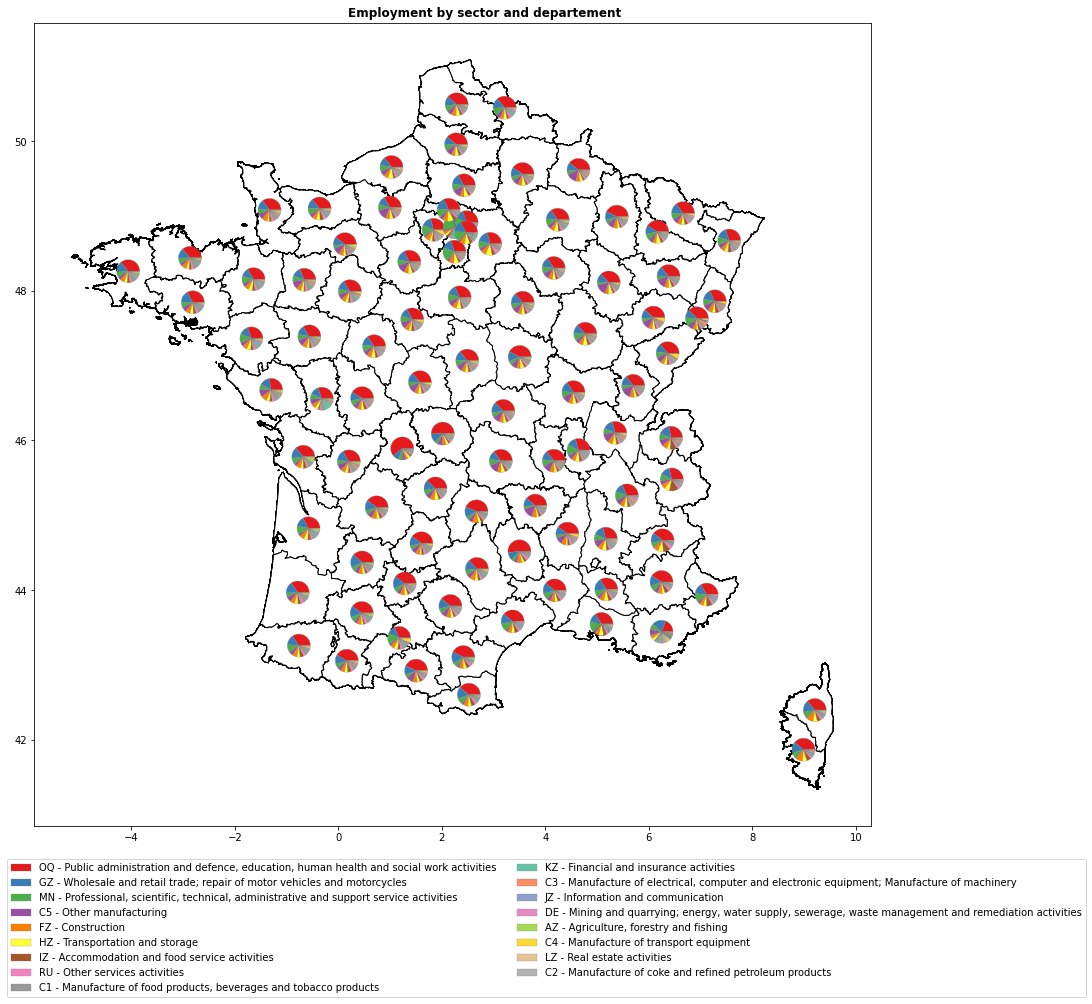

In [20]:
#draw plot

ax = datamap.plot(color='white', edgecolor='black', figsize = (15,15))

for idep in list_dep:
    df = datamap[datamap["CODEGEO"] == idep].reset_index(drop=True)
    ratios = df["employment_share"]
    Y, X = wkt.loads(df.loc[0, "center"]).xy
    lon, lat = Y[0], X[0]
    ax_sub = inset_axes(ax, width=0.4, height=0.4, loc=10, bbox_to_anchor=(lon, lat), bbox_transform=ax.transData)
    ax_sub.pie(ratios, wedgeprops={'edgecolor': 'gray','linewidth': 0.25}, colors = colors)
plt.legend(emplTot.index, loc='lower left', bbox_to_anchor=(-15, -27), ncol=2)
plt.title('Employment by sector and departement', x = -3, y = 7,
            horizontalalignment= 'left',
            fontsize = 12, fontweight='bold')
plt.show()

